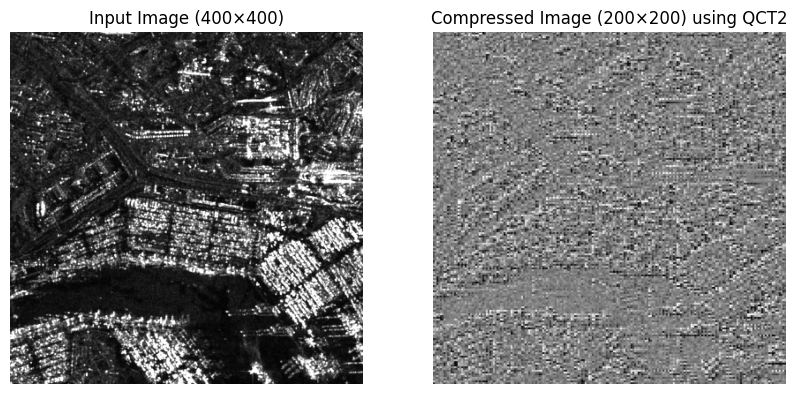

In [1]:
import cv2
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane.templates.embeddings import AmplitudeEmbedding

# Quantum Device with 4 qubits for compression
dev = qml.device("default.qubit", wires=4)

# Function for Quantum Compression using QCT2
@qml.qnode(dev)
def quantum_compression_qct2(data):
    """Quantum circuit that encodes classical data using QCT2 and measures via Pauli-Z."""
    
    # Normalize and Encode using Amplitude Embedding
    AmplitudeEmbedding(features=data, wires=[0, 1, 2, 3], normalize=True)
    
    # Apply Pauli-X transformations
    qml.PauliX(0)
    qml.PauliX(1)
    qml.PauliX(2)
    qml.PauliX(3)
    
    # Measure in Pauli-Z basis
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (400, 400))  # Resize to 400x400
    return img

# Split image into 4x4 blocks (16 pixels per block)
def split_into_blocks(image, block_size=4):
    blocks = []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size].flatten()
            blocks.append(block)
    return np.array(blocks)

# Normalize blocks for quantum encoding
def normalize_block(block):
    norm = np.linalg.norm(block)
    return block / norm if norm != 0 else block

# Apply quantum compression to image blocks
def compress_image(blocks):
    compressed_blocks = np.array([quantum_compression_qct2(normalize_block(block)) for block in blocks])
    compressed_blocks = np.interp(compressed_blocks, [-1, 1], [0, 255])  # Scale back to [0, 255]
    return compressed_blocks.astype(np.uint8)

# Reconstruct compressed image from quantum outputs
def reconstruct_image(compressed_blocks, img_size=200, block_size=2):
    compressed_image = np.zeros((img_size, img_size), dtype=np.uint8)
    index = 0
    for i in range(0, img_size, block_size):
        for j in range(0, img_size, block_size):
            compressed_image[i:i+block_size, j:j+block_size] = compressed_blocks[index].reshape((block_size, block_size))
            index += 1
    return compressed_image

# Main Execution
image_path = r"X:\College\BE\MajorProj\quantum\.venv\dataset_img1.png"  # Update to correct path
input_image = load_and_preprocess_image(image_path)
blocks = split_into_blocks(input_image)
compressed_blocks = compress_image(blocks)
compressed_image_QCT2 = reconstruct_image(compressed_blocks)

# Display input and compressed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title("Input Image (400×400)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(compressed_image_QCT2, cmap='gray')
plt.title("Compressed Image (200×200) using QCT2")
plt.axis("off")

plt.show()
